<a href="https://colab.research.google.com/github/OrionXV/AI7101-Project/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Problem Statement**


### **Problem Description**

Predict the operating status of water pumps in Tanzania—functional, needs repair, or non-functional. Reliable pumps are vital for rural communities, yet thousands of dispersed waterpoints must be maintained with limited resources.

### **Why This Problem Is Important**
**Cost Reduction:**  Focus spending on high-risk pumps and avoid unnecessary site visits.

**Resource Optimization:**  Allocate crews, spare parts, and funds where failure risk is highest.

**Community Impact:**  Faster repairs keep clean water available and reduce reliance on unsafe sources.

**Public Health & Livelihoods:**  Reliable water improves health outcomes and saves time.

### **How the ML Model Helps**

*	Proactive maintenance: Predict failures before breakdowns.
*  Prioritization: Classify pumps (functional / needs repair / non-functional) to rank urgency.
*	Operational efficiency: Fewer inspection trips and smarter crew routing.
*	Sustainability: Extend asset life and service reliability.

### **Expected Outcome**

*	Less downtime → more consistent access to clean water.
*	Lower operation & maintenance costs through targeted interventions.
*	Better planning for long-term infrastructure and investment.


In [1]:
!rm -rf AI7101-Project
!git clone https://github.com/OrionXV/AI7101-Project.git

Cloning into 'AI7101-Project'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 96 (delta 46), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (96/96), 7.24 MiB | 4.74 MiB/s, done.
Resolving deltas: 100% (46/46), done.


## Import the data
Load the data using pandas and split the data frame into X (inputs) and y (outputs). (2 points)

In [2]:
import warnings, sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", 100)

In [3]:
BASE_DIR = '/content/AI7101-Project/data'
SEED = 42
TRAIN_PATH        = os.path.join(BASE_DIR, 'train.csv')
TRAIN_TARGETS_PATH= os.path.join(BASE_DIR, 'training_labels.csv')
TEST_PATH         = os.path.join(BASE_DIR, 'test.csv')
SUBMISSION_PATH   = os.path.join(BASE_DIR, 'submission.csv')

In [4]:
train_features = pd.read_csv(TRAIN_PATH)
train_targets  = pd.read_csv(TRAIN_TARGETS_PATH)
test_df        = pd.read_csv(TEST_PATH)
submission = pd.read_csv(SUBMISSION_PATH)

In [5]:
df = train_features.merge(train_targets, on='id', how='inner', validate='one_to_one')
print("Merged training shape:", df.shape)
print("Class distribution:")
print(df['status_group'].value_counts(normalize=True))
X_raw = df.drop(columns=['status_group'])
y_raw = df['status_group']


Merged training shape: (59400, 41)
Class distribution:
status_group
functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: proportion, dtype: float64


## Prepare your dataset:
- encode categorical variables
- handle missing variables
- generate new features (if you have some intuition that these features can be helpful).
- Preprocess the target variable if needed (e.g., combine various classification problems into a single one or convert the target variable to a binary one).
- For each transformation, give a clear explanation of your motivation. (5 points)


In [6]:
print("Rows, cols:", df.shape)

print("\nTarget distribution (proportion):")
print(df['status_group'].value_counts(normalize=True).round(4))

print("\nTop missing columns (rate):")
print(df.isna().mean().sort_values(ascending=False).head(15).round(3))

print("\nNumber of unique values per column (top 15 by cardinality):")
print(df.nunique().sort_values().tail(15))

print("\nZero counts (selected numerics):")
for col in ['construction_year','gps_height','longitude','latitude','population','amount_tsh']:
    if col in df.columns:
        print(f"  {col}: {(df[col]==0).sum()}")

if 'date_recorded' in df.columns:
    dt = pd.to_datetime(df['date_recorded'], errors='coerce')
    rec_year = dt.dt.year
else:
    rec_year = pd.Series(index=df.index, dtype='float')
cy = df['construction_year'] if 'construction_year' in df.columns else pd.Series(index=df.index, dtype='float')
invalid_cy = (cy.isna()) | (cy==0) | (cy<1900) | ((~rec_year.isna()) & (cy > rec_year))
neg_naive = int(((rec_year - cy) < 0).fillna(False).sum())
print(f"\nconstruction_year issues → invalid={int(invalid_cy.sum())}, zeros={int((cy==0).sum())}, "
      f">recorded_year={int((~rec_year.isna() & (cy > rec_year)).sum())}, negative_naive_ages={neg_naive}")

for c in ['gps_height','longitude','latitude']:
    if c in df.columns:
        print(f"  {c} zeros: {(df[c]==0).sum()}")
if {'region','gps_height','longitude','latitude'}.issubset(df.columns):
    reg_meds = df.groupby('region')[['gps_height','longitude','latitude']].median(numeric_only=True)
    stds = reg_meds.std(numeric_only=True).round(3)
    print("Std of region medians (gps_height, lon, lat):", stds.to_dict())

print("\nHigh-cardinality (focus on funder/installer):")
for c in [col for col in ['funder','installer'] if col in df.columns]:
    s = df[c].astype('string').str.strip().str.lower()
    vc = s.value_counts(dropna=True)
    top20_cov = vc.head(20).sum()/vc.sum() if vc.sum() else 0
    print(f"  {c}: nunique={vc.shape[0]}, top20_coverage={top20_cov:.2%}")

# Booleans are messy — normalize to {true,false,unknown}
for c in ['public_meeting','permit']:
    if c in df.columns:
        s = df[c].astype('string').str.strip().str.lower()
        vc = s.value_counts(dropna=False).head(3)
        print(f"\n{c} raw top3:\n{vc}")

# Redundancy checks
pairs = [('payment','payment_type'), ('water_quality','quality_group'), ('source_type','source_class')]
print("\nHierarchy purity (fine -> coarse):")
for fine, coarse in pairs:
    if fine in df.columns and coarse in df.columns:
        g = df.groupby(fine)[coarse].nunique(dropna=False)
        print(f"  {fine}->{coarse}: purity={(g==1).mean():.3f}")

for c in [col for col in ['amount_tsh','population'] if col in df.columns]:
    x = pd.to_numeric(df[c], errors='coerce').clip(lower=0)
    print(f"Skew {c}: raw={x.dropna().skew():.2f} -> log1p={np.log1p(x).dropna().skew():.2f}")

if set(['wpt_name','latitude','longitude']).issubset(df.columns):
    key = (df['wpt_name'].astype('string').str.strip().str.lower() + '|' +
           df['latitude'].round(4).astype('string') + '|' +
           df['longitude'].round(4).astype('string'))
    counts = key.value_counts()
    print(f"\nNear-duplicate groups: {(counts>1).sum()} | share_of_rows={(counts[counts>1].sum()/len(df)):.3f}")

Rows, cols: (59400, 41)

Target distribution (proportion):
status_group
functional                 0.5431
non functional             0.3842
functional needs repair    0.0727
Name: proportion, dtype: float64

Top missing columns (rate):
scheme_name          0.485
scheme_management    0.065
installer            0.062
funder               0.061
public_meeting       0.056
permit               0.051
subvillage           0.006
wpt_name             0.000
id                   0.000
latitude             0.000
longitude            0.000
date_recorded        0.000
gps_height           0.000
amount_tsh           0.000
num_private          0.000
dtype: float64

Number of unique values per column (top 15 by cardinality):
num_private         65
amount_tsh          98
lga                125
date_recorded      356
population        1049
funder            1896
ward              2092
installer         2145
gps_height        2428
scheme_name       2695
subvillage       19287
wpt_name         37399
longitu

In [7]:
class BasicCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, top_n=20):
        self.top_n = top_n
        self.freq_maps_ = {}
        self.region_medians_ = None
        self.drop_candidates_ = [
            # Clear redundancy
            "recorded_by", # constant
            # drop grouped duplicates to avoid leakage/double counting
            "payment_type", "quality_group", "quantity_group",
            "source_type", "source_class",
            "waterpoint_type_group",
            "extraction_type_group",
        ]
        self.high_card_cols_ = ["funder", "installer", "subvillage", "scheme_name", "ward", "wpt_name"]
        self.boolish_cols_ = ["public_meeting", "permit"]
        self.skew_cols_ = ["amount_tsh", "population"]
        self.columns_to_drop_ = None

    def fit(self, X, y=None):
        X = X.copy()

        # Used to impute missing geographical values with something geographically sensible using the median
        if "region" in X.columns:
            self.region_medians_ = X.groupby("region")[["gps_height","longitude","latitude"]]\
                                     .median(numeric_only=True)
        else:
            self.region_medians_ = None

        # Frequency map for selected columns with high cardinality
        for col in self.high_card_cols_:
            if col in X.columns:
                ser = X[col].astype("string").str.strip().str.lower()
                self.freq_maps_[col] = ser.value_counts(dropna=True)

        # Identify the actual columns to drop
        self.columns_to_drop_ = [c for c in self.drop_candidates_ if c in X.columns]

        return self

    def _boolish(self, s):
        s = s.astype("string").str.strip().str.lower()
        out = np.where(s.isna(), "unknown",
              np.where(s.isin(["true","t","yes","y","1"]), "true",
              np.where(s.isin(["false","f","no","n","0"]), "false", "unknown")))
        return pd.Series(out, index=s.index, dtype="category")

    def transform(self, X):
        X = X.copy()

        # Parse dates & compute age
        if "date_recorded" in X.columns:
            dt = pd.to_datetime(X["date_recorded"], errors="coerce")
            X["recorded_year"] = dt.dt.year
            X["recorded_month"] = dt.dt.month
            X["recorded_dayofweek"] = dt.dt.dayofweek
            # construction_year: 0 => unknown
            if "construction_year" in X.columns:
                cy = X["construction_year"].replace(0, np.nan)
                X["age"] = (X["recorded_year"] - cy).where(cy.notna(), np.nan)
                # Invalid/negative ages -> NaN
                X.loc[X["age"] < 0, "age"] = np.nan
                X["age_decade"] = (np.floor(X["age"] / 10) * 10).astype("float")
            X.drop(columns=["date_recorded"], inplace=True)

        # Zeros -> NaN for geo/altitude
        for col in ["gps_height","longitude","latitude","construction_year"]:
            if col in X.columns:
                if col in ["construction_year","gps_height","longitude","latitude"]:
                    X[col] = X[col].replace(0, np.nan)

        # Adds binary flags to missing values
        for col in ["gps_height","longitude","latitude","construction_year"]:
            if col in X.columns:
                X[f"{col}_missing"] = X[col].isna().astype("int8")

        # Note the rows that have both longitude and latitude
        if "longitude" in X.columns and "latitude" in X.columns:
            X["has_geo"] = (~X["longitude"].isna()) & (~X["latitude"].isna())
            X["has_geo"] = X["has_geo"].astype("int8")

        # Log1p for skewed numerics
        for col in self.skew_cols_:
            if col in X.columns:
                X[f"{col}_log1p"] = np.log1p(X[col].clip(lower=0))

        # Normalize booleans to true/false/unknown categories
        for col in self.boolish_cols_:
            if col in X.columns:
                X[col] = self._boolish(X[col])

        # Frequency encodings AND top-N bucketing for high cardinality categoricals
        for col in self.high_card_cols_:
            if col in X.columns:
                ser = X[col].astype("string").str.strip().str.lower()
                freq = self.freq_maps_.get(col)
                X[f"{col}_freq"] = ser.map(freq).fillna(0).astype("float")
                # Top-N labels; others -> 'other'
                top = set(freq.head(self.top_n).index) if freq is not None else set()
                X[f"{col}_top"] = pd.Series(np.where(ser.isin(top), ser, "other"), index=ser.index, dtype="category")


        # Impute geo by region medians (then global median)
        if self.region_medians_ is not None:
            for col in ["gps_height","longitude","latitude"]:
                if col in X.columns:
                    X[col] = X[col].fillna(X["region"].map(self.region_medians_[col]))
                    X[col] = X[col].fillna(X[col].median())

        # Drop low-information / redundant columns if present
        to_drop = [c for c in self.columns_to_drop_ if c in X.columns]
        X.drop(columns=to_drop, inplace=True, errors="ignore")

        return X

In [8]:
# Apply cleaning / feature engineering
cleaner = BasicCleaner(top_n=20)
cleaner.fit(X_raw, y_raw)
X_eng = cleaner.transform(X_raw)

# Identify column types
cat_cols = [c for c in X_eng.columns if X_eng[c].dtype == "object" or str(X_eng[c].dtype) == "category"]
# Numeric columns include newly created *_freq, log features, etc.
num_cols = [c for c in X_eng.columns if c not in cat_cols and c != "id"]

# Treat numeric code columns as categoricals (they are codes, not true ordered numbers)
for code_col in ["region_code","district_code"]:
    if code_col in X_eng.columns:
        X_eng[code_col] = X_eng[code_col].astype("Int64").astype("string")
        if code_col not in cat_cols:
            cat_cols.append(code_col)
        if code_col in num_cols:
            num_cols.remove(code_col)

# Select low/medium-cardinality categoricals for OHE (threshold = 30 unique values)
low_card_cats = [c for c in cat_cols if X_eng[c].nunique(dropna=True) <= 30]

# Build preprocessing pipeline with imputation + OHE
numeric_transformer = SimpleImputer(strategy="median")
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat_low", categorical_transformer, low_card_cats),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

X_prepared = preprocessor.fit_transform(X_eng)
feature_names = list(num_cols) + list(preprocessor.named_transformers_["cat_low"].named_steps["onehot"].get_feature_names_out(low_card_cats))
X_prepared = pd.DataFrame(X_prepared, columns=feature_names, index=X_eng.index)

print("Engineered X shape:", X_eng.shape, "| Encoded X_prepared shape:", X_prepared.shape)
display(X_eng.head(3))
display(X_prepared.head(3))

Engineered X shape: (59400, 55) | Encoded X_prepared shape: (59400, 324)


,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_class,management,management_group,payment,water_quality,quantity,source,waterpoint_type,recorded_year,recorded_month,recorded_dayofweek,age,age_decade,gps_height_missing,longitude_missing,latitude_missing,construction_year_missing,has_geo,amount_tsh_log1p,population_log1p,funder_freq,funder_top,installer_freq,installer_top,subvillage_freq,subvillage_top,scheme_name_freq,scheme_name_top,ward_freq,ward_top,wpt_name_freq,wpt_name_top
0,69572,6000.0,Roman,1390.0,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,true,VWC,Roman,false,1999.0,gravity,gravity,vwc,user-group,pay annually,soft,enough,spring,communal standpipe,2011,3,0,12.0,10.0,0,0,0,0,1,8.699681,4.700480,275.0,other,94.0,other,6.0,other,139.0,other,36.0,other,3563.0,none
1,8776,0.0,Grumeti,1399.0,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,unknown,Other,NaN,true,2010.0,gravity,gravity,wug,user-group,never pay,soft,insufficient,rainwater harvesting,communal standpipe,2013,3,2,3.0,0.0,0,0,0,0,1,0.000000,5.638355,53.0,other,39.0,other,5.0,other,0.0,other,71.0,other,830.0,zahanati
2,34310,25.0,Lottery Club,686.0,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,true,VWC,Nyumba ya mungu pipe scheme,true,2009.0,gravity,gravity,vwc,user-group,pay per bucket,soft,enough,dam,communal standpipe multiple,2013,2,0,4.0,0.0,0,0,0,0,1,3.258097,5.525453,8.0,other,699.0,world vision,502.0,majengo,9.0,other,10.0,other,3.0,other


,amount_tsh,gps_height,longitude,latitude,num_private,population,construction_year,recorded_year,recorded_month,recorded_dayofweek,age,age_decade,gps_height_missing,longitude_missing,latitude_missing,construction_year_missing,has_geo,amount_tsh_log1p,population_log1p,funder_freq,installer_freq,subvillage_freq,scheme_name_freq,ward_freq,wpt_name_freq,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,region_Arusha,region_Dar es Salaam,region_Dodoma,region_Iringa,region_Kagera,region_Kigoma,region_Kilimanjaro,region_Lindi,region_Manyara,region_Mara,region_Mbeya,region_Morogoro,region_Mtwara,region_Mwanza,region_Pwani,region_Rukwa,...,wpt_name_top_sokoni,wpt_name_top_upendo,wpt_name_top_zahanati,region_code_1,region_code_10,region_code_11,region_code_12,region_code_13,region_code_14,region_code_15,region_code_16,region_code_17,region_code_18,region_code_19,region_code_2,region_code_20,region_code_21,region_code_24,region_code_3,region_code_4,region_code_40,region_code_5,region_code_6,region_code_60,region_code_7,region_code_8,region_code_80,region_code_9,region_code_90,region_code_99,district_code_0,district_code_1,district_code_13,district_code_2,district_code_23,district_code_3,district_code_30,district_code_33,district_code_4,district_code_43,district_code_5,district_code_53,district_code_6,district_code_60,district_code_62,district_code_63,district_code_67,district_code_7,district_code_8,district_code_80
0,6000.0,1390.0,34.938093,-9.856322,0.0,109.0,1999.0,2011.0,3.0,0.0,12.0,10.0,0.0,0.0,0.0,0.0,1.0,8.699681,4.700480,275.0,94.0,6.0,139.0,36.0,3563.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1399.0,34.698766,-2.147466,0.0,280.0,2010.0,2013.0,3.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,5.638355,53.0,39.0,5.0,0.0,71.0,830.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,25.0,686.0,37.460664,-3.821329,0.0,250.0,2009.0,2013.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,3.258097,5.525453,8.0,699.0,502.0,9.0,10.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Exploratory Analysis W/ Seaborn

- find meaningful patterns in the data that can be used to make a machine learning task more specific or to help with selection and tuning ML models.
- Perform additional data preprocessing if your findings suggest this (explain why).
- If there are several options for target variables, you can select some of them after this step with a couple of sentences explaining your choice. (4 points).

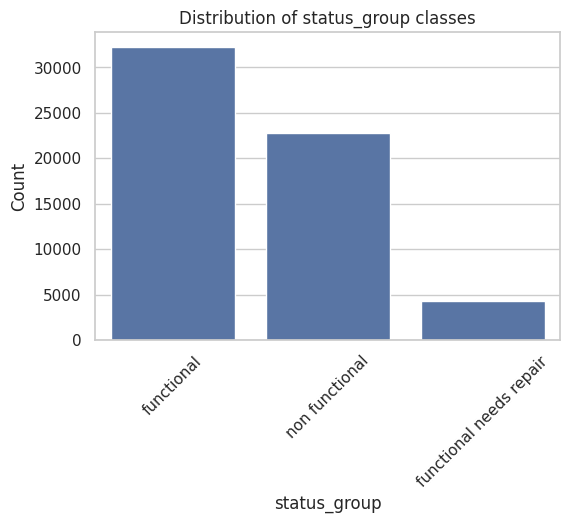

In [9]:
# distribution of the classes
plt.figure(figsize=(6,4))
sns.countplot(x=y_raw)
plt.title('Distribution of status_group classes')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.xlabel('status_group')
plt.show()

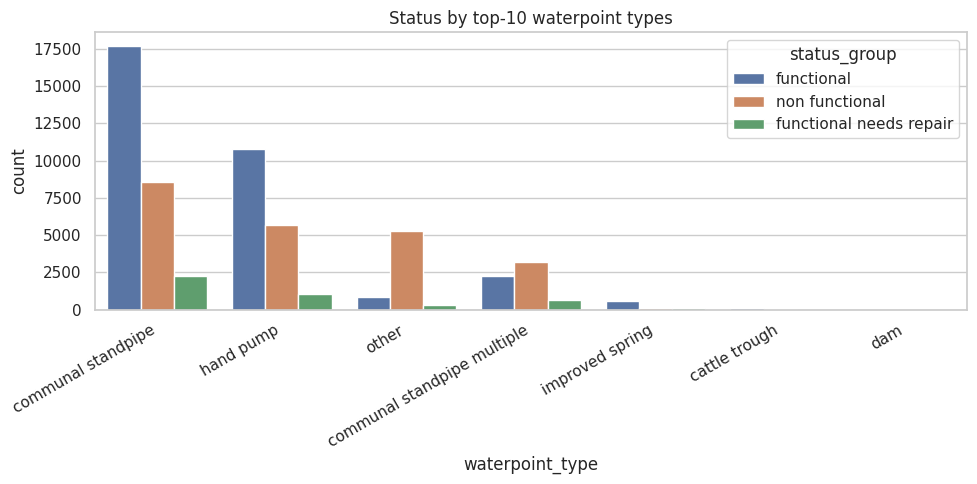

In [10]:
tmp = df[["waterpoint_type","status_group"]].dropna()
plt.figure(figsize=(10,5))
order = tmp["waterpoint_type"].value_counts().index[:10]
sns.countplot(data=tmp[tmp["waterpoint_type"].isin(order)],
              x="waterpoint_type", hue="status_group", order=order)
plt.title("Status by top-10 waterpoint types")
plt.xlabel("waterpoint_type")
plt.ylabel("count")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

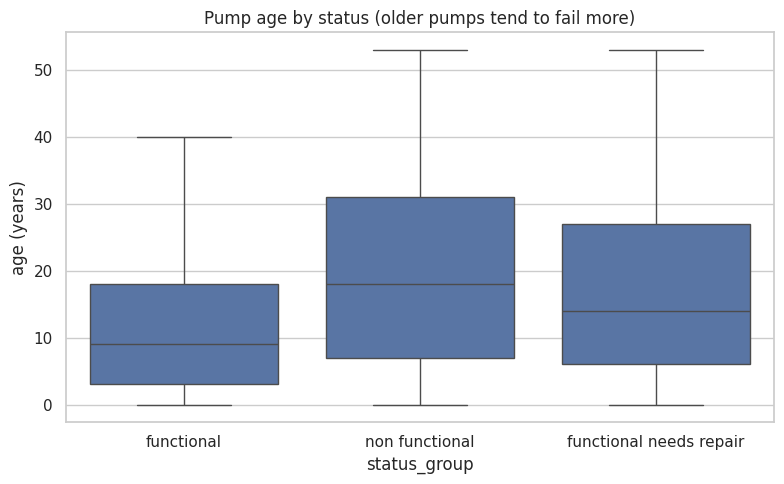

In [11]:
# this is to see whether the pump age effects the functionality of the pump
eng_for_plot = BasicCleaner(top_n=20).fit(df.drop(columns=["status_group"]), None).transform(df.drop(columns=["status_group"]))
eng_for_plot["status_group"] = df["status_group"]

plt.figure(figsize=(8,5))
sns.boxplot(data=eng_for_plot, x="status_group", y="age", showfliers=False)
plt.title("Pump age by status (older pumps tend to fail more)")
plt.xlabel("status_group")
plt.ylabel("age (years)")
plt.tight_layout()
plt.show()


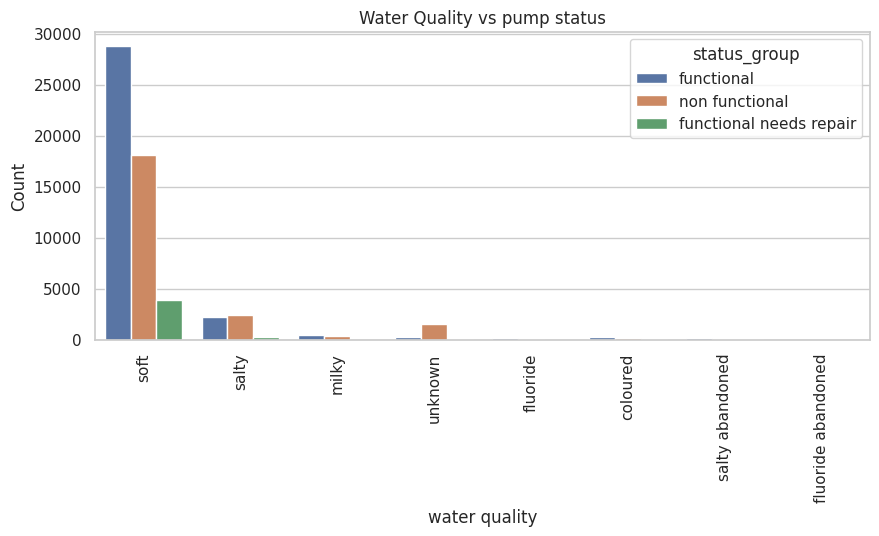

In [12]:
# to see if the water quality affects the functionality
plt.figure(figsize=(10,4))
sns.countplot(x=df['water_quality'], hue=y_raw)
plt.title('Water Quality vs pump status')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.xlabel('water quality')
plt.show()

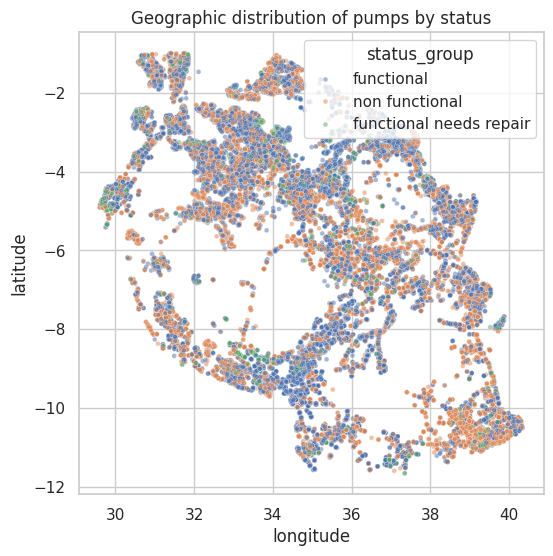

In [13]:
# to see if the geographical pattern affects the functionality of the pump
d = df[["longitude","latitude","status_group"]]
d = d[(d["longitude"] != 0) & d["latitude"].notna()]
plt.figure(figsize=(6,6))
sns.scatterplot(data=d, x="longitude", y="latitude", hue="status_group", alpha=0.5, s=12)
plt.title("Geographic distribution of pumps by status")
plt.show()

Text(0.5, 1.02, 'Pump locations by status')

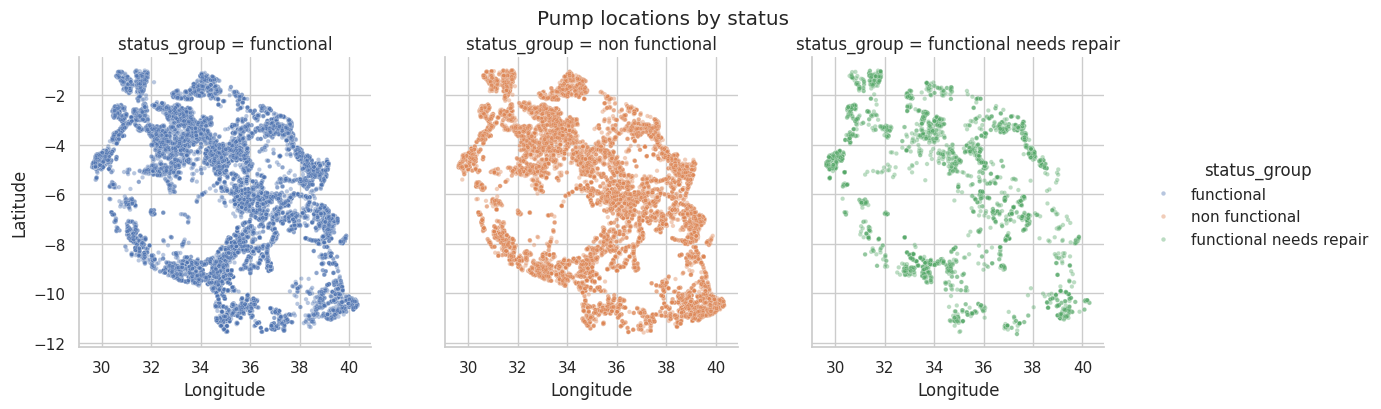

In [14]:
# previous graph isnt that obvious, so instead map each spatial area by class
d = df[['longitude','latitude','status_group']]
d = d[(d["longitude"] != 0) & d["latitude"].notna()]
g = sns.relplot(
    data=d, x='longitude', y='latitude',
    col='status_group', col_wrap=3, s=10, alpha=0.4, height=4, hue=y_raw
)
g.set(xlabel='Longitude', ylabel='Latitude', aspect='equal')
g.fig.suptitle('Pump locations by status', y=1.02)
# results show that no, it doesnt seem to really affect


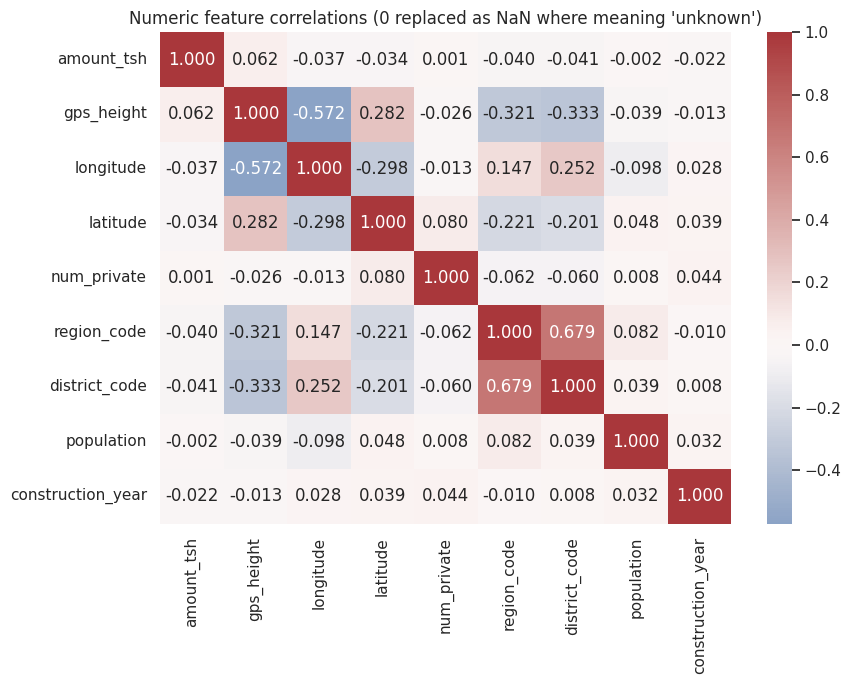

In [15]:
num_cols = [c for c in df.columns if df[c].dtype != 'object' and c not in ["id"]]
corr = df[num_cols].replace({0: np.nan}).corr()
plt.figure(figsize=(9,7))
sns.heatmap(corr, annot=True, cmap="vlag", center=0, fmt = ".3f")
plt.title("Numeric feature correlations (0 replaced as NaN where meaning 'unknown')")
plt.tight_layout()
plt.show()


## Cross-validation
- select an appropriate measure of quality (the selection of both things should be motivated by your data).
- Choose an ML model reasonably; look for a good set of hyperparameters.
- Use the prepared cross-validation procedure to estimate the quality of prediction (7 points).

In [16]:
from sklearn.model_selection import train_test_split, GridSearchCV
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y_raw.squeeze())

X_train, X_val, y_train, y_val = train_test_split(
    X_prepared, y,
    test_size=0.2,
    random_state=42,
)

In [17]:
lgb_estimator = lgb.LGBMClassifier(
    objective="multiclass",
    random_state=42
)

# we have already tried out the commented values, we commented it out because it'll take 20+ minutes to run the grid search again.
lgb_param_grid = {
    "n_estimators": [500], # 100, 200, 750
    "learning_rate": [0.1], # 0.01, 0.001, 0.0001
    "max_depth": [-1], # 8, 9
    "reg_alpha": [0], # 0.1, 0.25, 1     # L1
    "reg_lambda": [0] # 0.5, 1, 5
}

lgb_grid_search = GridSearchCV(
    estimator=lgb_estimator,
    param_grid=lgb_param_grid,
    scoring="f1_samples",
    cv=3,                # 3-fold CV
    verbose=2,
    n_jobs=-1
)

In [18]:
from xgboost import XGBClassifier

xgb_est = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    tree_method="hist",          # fast & memory-efficient; switch to "gpu_hist" if you have GPU
    random_state=42,
    n_jobs=-1
)

# we have already tried out the commented values, we commented it out because it'll take 20+ minutes to run the grid search.
xgb_param_grid = {
    "n_estimators": [300], # 600
    "learning_rate": [0.05], # 0.1, 0.01
    # "reg_alpha": [0, 1],     # L1
    # "reg_lambda": [0, 1, 5]  # L2
}

xgb_gs = GridSearchCV(
    estimator=xgb_est,
    param_grid=xgb_param_grid,
    scoring="f1_samples",
    cv=3,
    n_jobs=-1
)

In [19]:
lgb_grid_search.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="multi_logloss",
)

lgb_best_model = lgb_grid_search.best_estimator_
print("Best Params:", lgb_grid_search.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2906
[LightGBM] [Info] Number of data points in the train set: 47520, number of used features: 316
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.610699
[LightGBM] [Info] Start training from score -2.618149
[LightGBM] [Info] Start training from score -0.956876
Best Params: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 500, 'reg_alpha': 0, 'reg_lambda': 0}


In [20]:
xgb_gs.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False,                # suppress per-iteration logs
)

xgb_best = xgb_gs.best_estimator_
print("XGB Best Params:", xgb_gs.best_params_)

XGB Best Params: {'learning_rate': 0.05, 'n_estimators': 300}


In [21]:
y_val_pred = lgb_best_model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, target_names=le.classes_))

Validation Accuracy: 0.809006734006734
                         precision    recall  f1-score   support

             functional       0.80      0.90      0.85      6457
functional needs repair       0.59      0.31      0.41       851
         non functional       0.85      0.77      0.81      4572

               accuracy                           0.81     11880
              macro avg       0.75      0.66      0.69     11880
           weighted avg       0.80      0.81      0.80     11880



In [22]:
y_pred_xgb = xgb_best.predict(X_val)
print("XGB Validation Accuracy:", accuracy_score(y_val, y_pred_xgb))
print(classification_report(y_val, y_pred_xgb, target_names=le.classes_))

XGB Validation Accuracy: 0.7873737373737374
                         precision    recall  f1-score   support

             functional       0.76      0.93      0.83      6457
functional needs repair       0.70      0.22      0.34       851
         non functional       0.85      0.70      0.77      4572

               accuracy                           0.79     11880
              macro avg       0.77      0.61      0.65     11880
           weighted avg       0.79      0.79      0.77     11880



In [23]:
X_test_eng = cleaner.transform(test_df)
test_df_prepared = preprocessor.transform(X_test_eng)
y_test_pred = lgb_best_model.predict(test_df_prepared)
y_test_pred = le.inverse_transform(y_test_pred)
submission["status_group"] = y_test_pred
submission.to_csv("submission.csv", index=False)

submission.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
